In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import optuna
from optuna.trial import TrialState

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Epochs = 20
classes = 10

In [3]:
## get model from asignment 2 and check for acc and other metrices


In [4]:
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                       ])
target_t = lambda label: F.one_hot(torch.tensor(label), num_classes=10)

train_dataset = datasets.CIFAR10(root="./data", train=True, transform = t, target_transform=target_t, download=True)

test_dataset = datasets.CIFAR10(root="./data", train=False, transform = t, target_transform=target_t, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [6]:
label_names = ["airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog", 
"horse",
"ship",
"truck"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


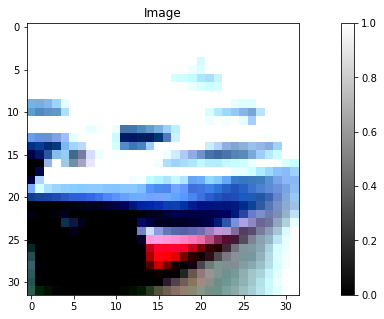

In [7]:
img = next(iter(test_loader))[0][1].permute(1,2,0)
label = next(iter(test_loader))[1][1]
def visual(img):
    img = img / 2 + 0.5
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)

    img = img.numpy()
    im = ax.imshow(img, cmap=plt.cm.gray)
    fig.colorbar(im)
    ax.set_title("Image")

visual(img)
print(label_names[torch.argmax(label)])


In [8]:
class Network(nn.Module):
    """
    This is the CNN architecture to evaluate CIFAR-10 dataset
    """
    def __init__(self, dropout: bool, name: str):
        super().__init__()
        
#         Input: (3, 32, 32)
        self.name = name
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

#         After Conv1 and maxpool: (6, 14, 14) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)

#         After Conv2 and maxpool: (16, 5, 5)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        self.dropout = dropout
        if self.dropout:
            self.in_dropout = nn.Dropout2d(p=0.2)
            self.cnn_dropout = nn.Dropout(p=0.5)
            self.lin_dropout = nn.Dropout(p=0.5)
        
        
    def forward(self, x):
        if self.dropout:
            x = self.in_dropout(x)
            x = self.maxpool(F.relu(self.cnn_dropout(self.conv1(x))))
            x = self.maxpool(F.relu(self.cnn_dropout(self.conv2(x))))
            x = torch.flatten(x, start_dim=1)
            x = F.relu(self.lin_dropout(self.fc1(x)))
            x = F.relu(self.lin_dropout(self.fc2(x)))
            x = self.fc3(x)
        else:
            x = self.maxpool(F.relu(self.conv1(x)))
            x = self.maxpool(F.relu(self.conv2(x)))
            x = torch.flatten(x, start_dim=1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        return x
    

In [9]:
model_with_dropout = Network(dropout=True, name="with_dropout")
model_without_dropout = Network(dropout=False, name="without_dropout")
# summary(model_without_dropout, (3,32,32)) 
#thowing error check

In [11]:
#training 
LR = 3e-4
# EVAL_FREQ = 1
# SAVE_FREQ = 10

# init_epoch = 0

In [12]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model_without_dropout.parameters(), lr=LR)

In [57]:

def training(model, EPOCHS=10):
#     Training time per epoch calculate and display
    model = model.to(device)
    loss_list = []
    stats = {
        "epoch": [],
        "train_loss": [],
        "valid_loss": [],
        "accuracy": []
    }
    
    for epoch in range(EPOCHS):
        epoch_loss = []
        running_loss = 0.0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for idx, (data, target) in pbar:
            data, target = data.to(device), target.type(torch.FloatTensor).to(device)
            optimizer.zero_grad()
            
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            
            running_loss =+ loss.item()
            epoch_loss.append(loss.item())
            
            
            if idx % 5 == 0:
                pbar.set_description(f"Epoch {epoch+1}, Itr {idx+1}, Loss {running_loss:.5f}")

        acc, v_loss = testing(model)        
        
        stats['epoch'].append(epoch)
        stats['train_loss'].append(np.mean(epoch_loss))
        stats['valid_loss'].append(v_loss)
        stats['accuracy'].append(acc.item())
        
        
        loss_list.append(np.mean(epoch_loss))
        
        if (epoch+1) % 1 == 0 or (epoch+1) == EPOCHS:
            saving_model(model, optimizer, epoch, stats)
        
    return loss_list



def testing(model):
    model = model.to(device)
    model.eval()
    total_corr = 0
    loss = []
    with torch.no_grad():
        total_corr = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.type(torch.float32).to(device)
            output = model(data)
            
            batch_loss = criterion(output, target)
            
            pred = torch.argmax(output, dim=1)
            gt = torch.argmax(target, dim=1)
            
            correct = torch.count_nonzero(pred == gt)
            total_corr += correct
            loss.append(batch_loss.item())
            
    accuracy = (total_corr/len(test_dataset))
    
    return accuracy, np.mean(loss)

def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



def saving_model(model, optimizer, epoch, stats):
    if not os.path.exists("models"):
        os.makedirs("models")
    save_path = f"models/{model.name}_{epoch}.pth"
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, save_path)
    


def loading_model(model, optimizer, path):
    checkpoint =  torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    stats = checkpoint['stats']
    return model, optimizer, epoch, stats

In [58]:
loss_without_dropout = training(model=model_without_dropout)
loss_with_dropout = training(model=model_with_dropout)

Epoch 10, Itr 96, Loss 2.30254: 100%|███████████| 98/98 [00:07<00:00, 12.78it/s]


In [60]:
cnn = Network(dropout=False, name="model")
# optimizer =
cnn, optimizer, epoch, stats = loading_model(cnn, optimizer, "models/without_dropout_9.pth")

In [61]:
acc_1, _ = testing(model_with_dropout)
acc_2, _ = testing(model_without_dropout)

print(f"The Acc of the model with dropout is: {acc_1 * 100}")
print(f"The Acc of the model without dropout is: {acc_2 * 100}")

The Acc of the model with dropout is: 9.299999237060547
The Acc of the model without dropout is: 54.71999740600586


In [62]:
print(f"Number of params with dropout {num_params(model_with_dropout)}")
print(f"Number of params without dropout {num_params(model_without_dropout)}")

Number of params with dropout 62006
Number of params without dropout 62006


### Training loss plots 

In the figure below is the training loss of various models:
*append more*

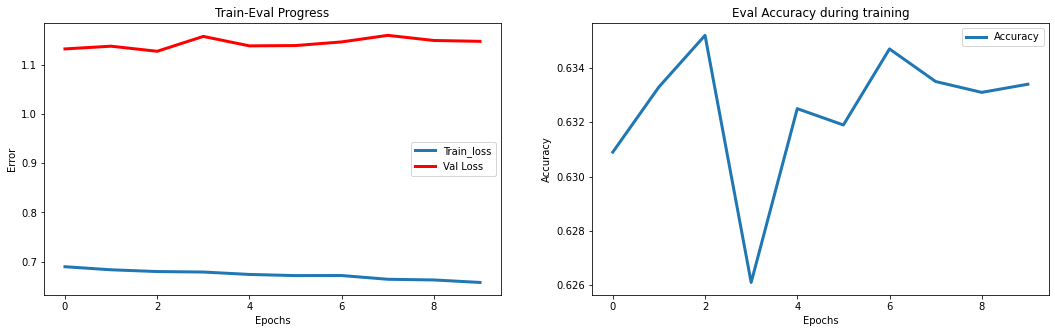

In [63]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18, 5)

ax[0].plot(stats['epoch'], stats['train_loss'], label="Train_loss", linewidth=3)
ax[0].plot(stats['epoch'], stats['valid_loss'], label="Val Loss", c='red', linewidth=3)
ax[0].legend(loc='best')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
    
ax[0].set_title("Train-Eval Progress")


ax[1].plot(stats['epoch'], stats['accuracy'], label="Accuracy", linewidth=3)
ax[1].legend(loc='best')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
    
ax[1].set_title("Eval Accuracy during training")


plt.show()

### Visualizing the kernels

Here we are visualizing the kernels

In [124]:
keys = list(cnn.state_dict().keys())
def vis_kernel(kernels):
    n,c,w,h = kernels.shape
    fig, ax = plt.subplots(1,6)
    
    for idx, i in enumerate(kernels):
        
        img = i.squeeze().permute(1,2,0).numpy()
        ax[idx].imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


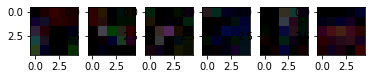

In [125]:
vis_kernel(cnn.state_dict()[keys[0]])